<a href="https://colab.research.google.com/github/FarahZayed/Qr-detector/blob/master/cv_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **import** **libraries**

In [25]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image, ImageFilter
import math
from matplotlib import pyplot as plt

# Read the image

In [154]:
#insert the path of the image
img = cv2.imread("/content/13-2el-noor-2ata3.png", cv2.IMREAD_GRAYSCALE)
_, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)


#  Function ma7tgnha

In [148]:
def invert_image(image):

    inverted_gray = 255 - image


    inverted_image = cv2.cvtColor(inverted_gray, cv2.COLOR_GRAY2BGR)

    return inverted_image



def angle_ABC(a, b, c):


    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def find_bad_dists(hull, distance = 10):
    mask = []
    points, _, _ = hull.shape

    for i in range(points):
        # determine points to compare and make sure that last and first are compared too
        ai = i
        bi = (i+1)%points
        # x, y for both points
        x1 = hull[ai][0][0]
        y1 = hull[ai][0][1]
        x2 = hull[bi][0][0]
        y2 = hull[bi][0][1]

        #distance
        dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 )
        #build mask with distances out ot range
        if dist < distance:
            print('point nr =', bi, ' -> distance =',dist)
            mask.append(bi)
    return mask



def find_bad_angles(hull, acute_angle = 30, obtuse_angle = 140):

    mask = []
    points, _, _ = hull.shape

    for i in range(points):
        # determine points to compare angle and make sure that last and first are compared too
        ai = i
        bi = (i+1)%points
        ci = (i+2)%points


        a = hull[ai][0]
        b = hull[bi][0]
        c = hull[ci][0]
        angle = angle_ABC(a, b, c)
        if angle > obtuse_angle or angle < acute_angle:
            mask.append(bi)
    return mask

def mark_points(hull):
    a_list=[]
    points, _, _ = hull.shape

    for i in range(points):
        r = int(np.random.randint(100,255,1)[0])
        g = int(np.random.randint(100,255,1)[0])
        b = int(np.random.randint(100,255,1)[0])
        a_list.append(tuple([hull[i][0][0], hull[i][0][1]]))

    return a_list



def shahd(img,thresh):

        invimg = invert_image(img)

        invg = cv2.cvtColor(invimg,cv2.COLOR_RGB2GRAY)
        ret,thresh = cv2.threshold(invg,127,255,0)

        contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        image =  invg = cv2.cvtColor(invg,cv2.COLOR_GRAY2RGB)
        length = len(contours)
        cont = np.concatenate([contours[i] for i in range(length)], axis=0)

        cnt_len = cv2.arcLength(cont, True)
        cont = cv2.approxPolyDP(cont, .01*cnt_len, True)
        hull = cv2.convexHull(cont)


        mask = find_bad_dists(hull)
        hull = np.delete(hull, mask, axis=0)

        mask = find_bad_angles(hull)
        hull = np.delete(hull, mask, axis=0)

        a_list=mark_points(hull)

        uni_hull = []
        uni_hull.append(hull)
        cv2.drawContours(image,uni_hull,-1,255,2)


        shahdlist =  mark_points(hull)
        print("+++++++++++")
        return shahdlist


In [149]:
def remove_quietnoise(img):
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1
    for row_index, row in enumerate(img):
     for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
     if start_row != -1:
        break
    for row_index, row in enumerate(img[::-1]):
     for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
     if end_row != -1:
        break
    for col_index, col in enumerate(cv2.transpose(img)):
     for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
     if start_col != -1:
        break
    for col_index, col in enumerate(cv2.transpose(img)[::-1]):
     for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
     if end_col != -1:
        break
    qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
    return qr_no_quiet_zone

    fig = plt.figure(figsize=(5, 5));
    plt.xticks([], []);
    plt.yticks([], []);
    fig.get_axes()[0].spines[:].set_color('red');
    fig.get_axes()[0].spines[:].set_linewidth(40);
    fig.get_axes()[0].spines[:].set_position(("outward", 20))
    plt.title('QR code without quiet zone', y = 1.15, color='red');
    plt.imshow(qr_no_quiet_zone, cmap='gray');

def get_start_row_col(img):
    start_row = -1
    start_col = -1
    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel != 255:
                start_row = row_index
                break
        if start_row != -1:
            break
    for col_index, col in enumerate(cv2.transpose(img)):
        for pixel in col:
            if pixel != 255:
                start_col = col_index
                break
        if start_col != -1:
            break
    return start_row, start_col


def getcellsizeForRotation(imgremove):
    size=0
    for pixel in imgremove[-1, ::-1]:
      if (pixel != 0): break
      size += 1
    return 0
    grid_cell_size = round(size/7)
    grid_cells_num = round(imgremove.shape[0]/grid_cell_size)
    return grid_cell_size,grid_cells_num

def getqrcell(remove):
    if remove.shape[0] % grid_cell_size != 0 or remove.shape[1] % grid_cell_size != 0:
            print("Warning: Grid cell size resulted in fraction. Adjusting...")
            img_resized = cv2.resize(remove, (924, 924))

    # If the resized image is larger than the target size, crop it
            if remove.shape[0] > 924 or remove.shape[1] > 924:
                remove = img_resized[:924, :924]
            else:
                remove = img_resized
    try:
            qr_cells = remove.reshape((
            grid_cells_num,
            grid_cell_size,
            grid_cells_num,
            grid_cell_size,
            )).swapaxes(1, 2)

    except ValueError:
        print("Error: Unable to reshape image into grid cells.")
        qr_cells=0
    return qr_cells

def correctqrcell(qr_cells):

 for i in range(qr_cells.shape[0]):
   for j in range(qr_cells.shape[1]):
    cell=qr_cells[i][j]
    white_pixel_count = np.sum(cell == 255)
    black_pixel_count = np.sum(cell == 0)
    if white_pixel_count > black_pixel_count:
        for k in range(grid_cell_size):
            for l in range(grid_cell_size):
                qr_cells[i][j][k][l]=255
    elif black_pixel_count > white_pixel_count:
        for k in range(grid_cell_size):
            for l in range(grid_cell_size):
                qr_cells[i][j][k][l]=0


    elif black_pixel_count == white_pixel_count:
        for k in range(grid_cell_size):
            for l in range(grid_cell_size):
                qr_cells[i][j][k][l]=0
    return qr_cells


# function that get flags

In [158]:
#Note: rotation hat crash fi sorten 3ashan el binrization bytl3 kolo aswd aw kolo abyd fa mmken na3ml binarize 7asb el case
#mesh 3arfa nashof?? PLUS el banana mafrod ttl3 anha rotated!!! mesh 3arf bardo
def checkrotation(img):
    imgremove= remove_quietnoise(img)
    grid_cell_size= getcellsizeForRotation(imgremove)
    if grid_cell_size==0:
        print("The image is not rotated it may have some other noise that must be solved first!!!")
        return False
    inverted_img = cv2.bitwise_not(imgremove)
    shapeofste=3*grid_cell_size -1
    se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (shapeofste, shapeofste))
    _, se_binarized = cv2.threshold(se_rect, 128, 1, cv2.THRESH_BINARY)
    se_binarized = se_binarized.astype(int)
    se_binarized[se_binarized == 0] = -1
    erosion = cv2.erode(inverted_img, se_rect, iterations=1)
    plt.imshow(erosion,cmap='gray');
    partwithrotato=erosion[(imgremove.shape[0]-7*grid_cell_size):imgremove.shape[0], imgremove.shape[1]-7*grid_cell_size:imgremove.shape[1]];
    for row in range(partwithrotato.shape[0]):
        for col in range(partwithrotato.shape[1]):
            if partwithrotato[row,col] == 255:
                print("ROTATEDDD!!!")
                return True
    print("NOT ROTATED!!!")
    return False


def checkblured(image):
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20*np.log(np.abs(f_transform_shifted))


    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    avg_gradient_magnitude = np.mean(gradient_magnitude)

    frequency_threshold_max = 375
    frequency_threshold_min=300
    gradient_threshold_max =35
    gradient_threshold_min= 20

    if (frequency_threshold_min>np.max(magnitude_spectrum) or  frequency_threshold_max < np.max(magnitude_spectrum) ) or ( avg_gradient_magnitude > gradient_threshold_max or avg_gradient_magnitude<gradient_threshold_min):
        return False
    else:
        return True

#check mostly white
def is_mostly_white(img):
    row, col = img.shape
    count=0
    plt.show()
    for i in range(row):
        for j in range(col):
            if (img[i][j] < 180) or (img[i][j] > 230) :
                count=count+1
    if count>0:
       return False
    else:
        return True

#check shifting
def detect_shift_rows(img):
    start_row,start_col=get_start_row_col(img)
    if start_row>0 and start_col>0 and start_col!=start_row:
        if (start_row-start_col)<20 and (start_row-start_col)>10 :
            return True
        else:
          return False
    else:
      return False


#checks skewness
def checkskew(img):
    edges = cv2.Canny(img, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if(contours ==() ):
        return False
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    qr_code_region = img[y:y + h, x:x + w]
    edges = cv2.Canny(qr_code_region, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)
    if lines is None:
        return False
    vertical_angles = []
    horizontal_angles = []

    for line in lines:
        rho, theta = line[0]
        if np.pi / 4 < theta < 3 * np.pi / 4:
            vertical_angles.append(theta)
        else:
            horizontal_angles.append(theta)
    vertical_skewness = np.mean(vertical_angles) if vertical_angles else 0
    horizontal_skewness = np.mean(horizontal_angles) if horizontal_angles else 0

    vertical_skewness_deg = round(np.rad2deg(vertical_skewness))
    horizontal_skewness_deg = round(np.rad2deg(horizontal_skewness))

    difference=round(abs(horizontal_skewness_deg - vertical_skewness_deg))
    if(difference==90 and vertical_skewness_deg!=90 and horizontal_skewness_deg!=90):
        return True
    else:
        return False


#check black image
def is_mostly_black(image, threshold=0.9):

    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    hist /= hist.sum()

    cumulative_sum = hist.cumsum()

    threshold_index = (cumulative_sum > threshold).argmax()

    return threshold_index < 10


# flags to do preprocessing

In [159]:
rotationflag= checkrotation(img)
bluredflag =checkblured(img)
shiftedrowsflag= detect_shift_rows(img)
mostlywhiteflag= is_mostly_white(img)
skewedflag = checkskew(img)
mostlyblackflag=is_mostly_black(img)
print("The flag of rotation: ",rotationflag )
print("The flag of all white image: ",mostlywhiteflag )
print("The flag of blured image: ",bluredflag )
print("The flag of shifted rows: ",shiftedrowsflag )
print("The flag of skewed images : ",skewedflag )
print("The flag of all black image : ",mostlyblackflag )


The image is not rotated it may have some other noise that must be solved first!!!
The flag of rotation:  False
The flag of all white image:  False
The flag of blured image:  False
The flag of shifted rows:  False
The flag of skewed images :  False
The flag of all black image :  True


# Function responsible for preprocessing

In [162]:
def a3dlrotation(img):
    imgremove= remove_quietnoise(img)
    while(checkrotation(imgremove)):
        imgremove = cv2.rotate(imgremove, cv2.ROTATE_90_CLOCKWISE)
    return imgremove

def nadafblured(img):
         # nazbt el soraa
        blurred = cv2.GaussianBlur(img, (7, 7), 0)
        sharpened = cv2.addWeighted(img, 2.5, blurred, -0.5, 0)
        _, thresh_img = cv2.threshold(sharpened, 127, 255, cv2.THRESH_BINARY)
        #shalena el noise w shwait araf erode keda
        remove= remove_quietnoise(thresh_img)
        se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
        _, se_binarized = cv2.threshold(se_rect, 128, 1, cv2.THRESH_BINARY)
        se_binarized = se_binarized.astype(int)
        se_binarized[se_binarized == 0] = -1
        erosion = cv2.erode(remove, se_binarized, iterations=1)
        needcorrectionimg=erosion
        #this erosion to get the correct cell size
        while(erosion[0][0]!=0):
          erosion = cv2.erode(erosion, se_binarized, iterations=1)
        grid_cell_size,grid_cells_num=getimageafterreshape(erosion)
        qr_cells=getqrcell(needcorrectionimg)
        qr_cells=correctqrcell(qr_cells)
        return qr_cells

def skewed(img,thresh):
        listt  = shahd(img,thresh)
        rows1 , cols1  = img.shape
        pts2 = np.array([[cols1,rows1],[0,rows1],[0,0], [cols1,0]],np.float32)
        pts1 = np.array(listt,np.float32)
        M = cv2.getPerspectiveTransform(pts1,pts2)
        dst = cv2.warpPerspective(img,M,(cols1,rows1))
        plt.imshow(dst,cmap='gray')
        plt.axis('off')
        plt.title('AFTER')
        #3ayzen nrg3 imgg mesh plot


def edit_white_img(img):
    first_pixel=img[0,0]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == first_pixel:
                img[i][j] = 225
            else:
                img[i][j] = 0
    return img



def solve_shifted_rows(img):
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel != 255:
                start_row = row_index
                start_col =row_index
                break
        if start_row != -1:
            break

    for row_index, row in enumerate(img[::-1]):
        for pixel in row:
            if pixel != 255:
                end_row = img.shape[0] - row_index
                end_col =img.shape[0] - row_index
                break
        if end_row != -1:
            break


    qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]

    size = 0
    for pixel in qr_no_quiet_zone[0]:
        if (pixel != 0): break
        size += 1

    grid_cell_size = round(size/7)
    grid_cells_num = round(qr_no_quiet_zone.shape[0]/grid_cell_size)

    img_resized = cv2.resize(qr_no_quiet_zone, (grid_cells_num*grid_cell_size, grid_cells_num*grid_cell_size))

    qr_cells = img_resized.reshape((
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
    )).swapaxes(1, 2)
    qr_cells= correctqrcell(qr_cells)  #BRWANAA ANA NADT FUNCTION 3ASHAN ANA KMAN BST5DMHA
    # BRWANA 3AYZHA HENA LEHHH
    # for i in range(qr_cells.shape[0]):
    #     for j in range(qr_cells.shape[1]):
    #         cell=qr_cells[i][j]
    #         white_pixel_count = np.sum(cell == 255)
    #         black_pixel_count = np.sum(cell == 0)
    #         if white_pixel_count > black_pixel_count:
    #             for k in range(grid_cell_size):
    #                 for l in range(grid_cell_size):
    #                     qr_cells[i][j][k][l]=255
    #         elif black_pixel_count > white_pixel_count:
    #             for k in range(grid_cell_size):
    #                 for l in range(grid_cell_size):
    #                     qr_cells[i][j][k][l]=0


    #         elif black_pixel_count == white_pixel_count:
    #             for k in range(grid_cell_size):
    #                 for l in range(grid_cell_size):
    #                     qr_cells[i][j][k][l]=0
    return img_resized


def dalma(image):
        thresh,binary_image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)
        image = cv2.inpaint(image, binary_image, inpaintRadius=3,flags=cv2.INPAINT_TELEA)

        #SHAHDD 3AYZA DAHH
        fig = plt.figure(figsize=(5, 5))
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title('13 QR code')
        plt.imshow(image, cmap='gray')
        raw=image

        mask = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY)[1]

        lightened_image = np.where(mask == 255, np.clip(image * 100, 0, 255).astype(np.uint8), image)

        #SHAHDD 3AYZA DAHH
        fig = plt.figure(figsize=(5, 5));
        plt.xticks([], []);
        plt.yticks([], []);
        plt.title('light 13 QR code')
        plt.imshow(lightened_image, cmap='gray');


        _, mask = cv2.threshold(lightened_image, 75, 255, cv2.THRESH_BINARY)

        mask = cv2.bitwise_not(mask)

        _, bimage = cv2.threshold(lightened_image, 0, 255, cv2.THRESH_BINARY)
        #SHAHDD 3AYZA DAHH
        fig = plt.figure(figsize=(5, 5))
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title('adaptive QR code')
        plt.imshow(bimage, cmap="gray")
        #SHAHD HIA BT RETURN EHH
        return bimage

# def orientSkewness():

#         # Calculate the rotation angle to correct skewness
#         rotation_angle_deg = 180+horizontal_skewness_deg  # Start with the horizontal skewness angle

#         # Perform the rotation
#         rows, cols = img.shape[:2]
#         rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle_deg, 1)
#         img = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR,
#                                     borderMode=cv2.BORDER_REPLICATE)

#         qr_code_region = cv2.warpAffine(qr_code_region, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR,
#                             borderMode=cv2.BORDER_CONSTANT)

#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
#         contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#         # Get the largest contour (assumed to be the QR code)
#         largest_contour = max(contours, key=cv2.contourArea)

#         # Get the minimum area rectangle bounding the contour
#         rect = cv2.minAreaRect(largest_contour)

#         # Get the angle of rotation
#         angle = rect[-1]

#         # Ensure the angle is within the range (-45, 45)
#         if angle < -45:
#             angle += 90

#         # Rotate the image to correct skewness
#         rows, cols = img.shape[:2]
#         rotation_matrix = cv2.getRotationMatrix2D(rect[0], angle, 1)
#         rotated_image = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR,
#                                     borderMode=cv2.BORDER_REPLICATE)

#         # Add a white border around the rotated image
#         border_width = 20  # Adjust the border width as needed
#         border_color = (255, 255, 255)  # White color
#         img = cv2.copyMakeBorder(img, border_width, border_width, border_width, border_width,
#                                             cv2.BORDER_CONSTANT, value=border_color)


# Preprocessing

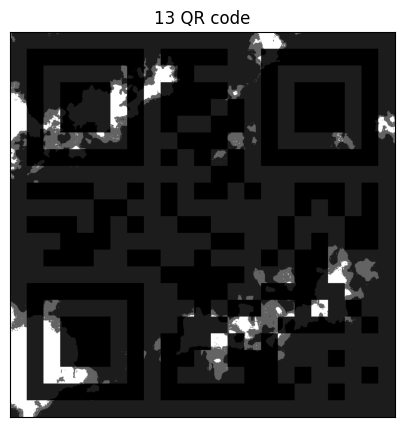

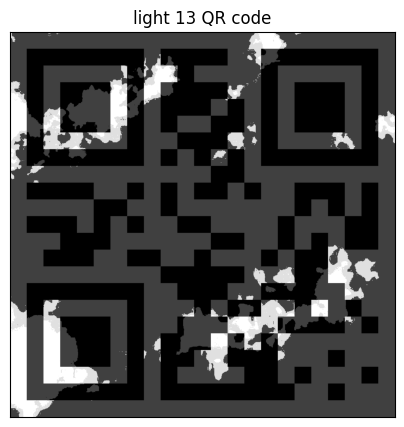

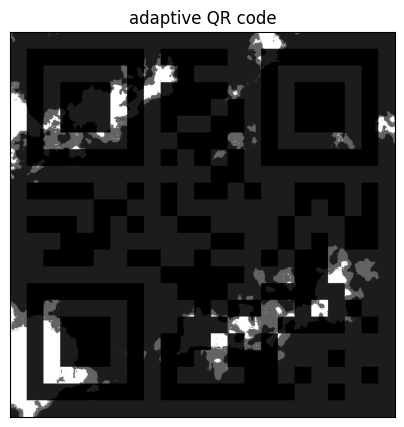

In [163]:
imgafterpreproc=img
if(rotationflag==True):
    imgafterpreproc= a3dlrotation(img)
if(bluredflag==True):
    imgafterpreproc= nadafblured(img)
if(mostlywhiteflag==True):
    imgafterpreproc=edit_white_img(img)
if(shiftedrowsflag==True):
    imgafterpreproc = solve_shifted_rows(img)
if(mostlyblackflag==True):
    imfafterpreproc=dalma(img)
if(skewedflag ==True):
    ##
#ba2et el if
plt.imshow(imgafterpreproc,cmap='gray')

pts1
[[718. 847.]
 [ 61. 952.]
 [317. 197.]
 [970.  93.]]


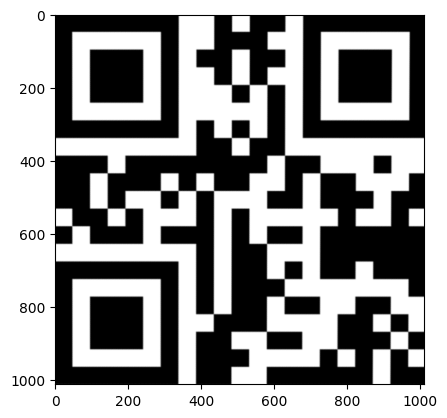

In [ ]:
# cv2_imshow(img)
# img = cv2.cvtColor(img,cv2.THRESH_BINARY)
real=img
rows1,cols1=real.shape


# [100,100],[1022,100],[100,1022],[1022,1022]
pts2 = np.float32([[cols1,rows1],[0,rows1],[0,0], [cols1,0]])
pts1 = np.float32(a_list)

# M = cv2.getAffineTransform(pts1,pts2)

# dst = cv2.warpAffine(img,M,(cols,rows))
print("pts1")
print(pts1)

# M = cv2.getAffineTransform(pts1, pts2)
# dst = cv2.warpAffine(sora, M, (cols1, rows1))

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(real,M,(cols1,rows1))

# erode = erode_image(dst)



#back = add_border(dilated)
# [316,197],[974,93],[61,952],[718,847]

# fig.add_subplot(1, 2, 2)
# plt.imshow(dst)
# plt.axis('off')
# plt.title('AFTER')


plt.imshow(dst,cmap='gray')


# **Reshape** hy5osh 3ala decode

In [ ]:
#later note:mmken nb2a nashel el condition el zayda wala ba an el sora ela 7ad ma htro7 mazbota shwia

def getimageafterreshape(img):
    #dah 3ak ATSRFYYYY
    if(img[0][0]==255):
        imgremove,_,_ = remove_quietnoise(img)

    else:
        inverted_img = cv2.bitwise_not(img)            #noha 3ayza el invert hena
        imgremove,_,_ = remove_quietnoise(inverted_img)

    size = 0

    #h8yr hena leh 3ashan el taree2 dih mesh htnf3 3ala kol el sewar zay el rotated fa ana h7sb el 3aded el pixel bel change w inshallah 5er
    if(imgremove[0][0]==255):
        for pixel in imgremove[-1, ::-1]:
         if (pixel != 0): break
         size += 1

    else:
        for pixel in imgremove[0]:
         if (pixel != 0): break
         size += 1
    grid_cell_size = round(size/7)
    print(grid_cell_size)
    grid_cells_num = round(imgremove.shape[0]/grid_cell_size)
    print(grid_cells_num)
    #NOHAAA
    if imgremove.shape[0] % grid_cell_size != 0 or imgremove.shape[1] % grid_cell_size != 0:
        print("Warning: Grid cell size resulted in fraction. Adjusting...")
        img_resized = cv2.resize(imgremove, (924, 924))

# If the resized image is larger than the target size, crop it

        if img_resized.shape[0] > 924 or img_resized.shape[1] > 924:
            imgremove = img_resized[:924, :924]
        else:
            imgremove = img_resized


            #cv2_imshow(imgremove)

    try:

        qr_cells = imgremove.reshape((
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
        )).swapaxes(1, 2)
        plt.imshow(imgremove,cmap='gray')
        _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
        for i, row in enumerate(axes):
          for j, col in enumerate(row):
              col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
              col.get_xaxis().set_visible(False)
              col.get_yaxis().set_visible(False)
              col.spines[:].set_color('red')


        return qr_cells,grid_cells_num,grid_cell_size,imgremove

    except ValueError:
        print("Error: Unable to reshape image into grid cells.")
        return "none",grid_cells_num,grid_cell_size,imgremove



#plt.imshow(imgremove,cmap='gray')

#salama
# print(size)
# grid_cell_size = round(size/7)
# print(grid_cell_size)
# grid_cells_num = round(imgremove.shape[0]/grid_cell_size)
# print(grid_cells_num)
# qr_cells = imgremove.reshape((
#     grid_cells_num,
#     grid_cell_size,
#     grid_cells_num,
#     grid_cell_size,
# )).swapaxes(1, 2)
# plt.imshow(imgremove,cmap='gray')
# _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
# for i, row in enumerate(axes):
#     for j, col in enumerate(row):
#         col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
#         col.get_xaxis().set_visible(False)
#         col.get_yaxis().set_visible(False)
#         col.spines[:].set_color('red')


# Decode

In [ ]:
def change_binary(qr_cell,grid_cell_num):
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    return qr_cells_numeric

In [ ]:
def getecl(qr_cells_numeric):
    qr_cells_numeric[8]
    # The first two bits determine the error correction level
    # Level L (Low)         [11]	7%  of data bytes can be restored.
    # Level M (Medium)      [10]	15% of data bytes can be restored.
    # Level Q (Quartile)    [01]	25% of data bytes can be restored.
    # Level H (High)        [00]	30% of data bytes can be restored.
    ecl = [int(not(c)) for c in qr_cells_numeric[8, 0:2]]
    # Why "not"? Because the standard uses '1's for black and '0's for white
    #
    # "A dark module is a binary one and a light module is a binary zero."
    #  - ISO/IEC 18004:2000(E)
    #
    # In image processing, we use them the other way.. Hence the inversion
    return ecl

def get_mask(qr_cells_numeric):
    # Dictionary of all masks and their equivalent formulae
    # Same row as above, the three cells after the ecl cells (converted to a string)
    mask = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
    mask_str = ''.join([str(c) for c in mask])
    return mask,mask_str

def get_fec(qr_cells_numeric):
    fec = []
    fec.append(qr_cells_numeric[8, 5])
    fec.append(qr_cells_numeric[8, 7])
    fec.extend(qr_cells_numeric[0:6, 8])
    fec.extend(qr_cells_numeric[7:9, 8])
    fec = [int(not(c)) for c in fec]
    return fec


#def showneededpixel(qr_cells_numeric):
#    _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
#    for i, row in enumerate(axes):
#        for j, col in enumerate(row):

            # col.get_xaxis().set_visible(False)
            # col.get_yaxis().set_visible(False)
            # if (i == 8 and j <= 8) or (i <= 8 and j == 8):
            #     if (i != 6) and (j != 6):
            #         col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
            #         col.spines[:].set_color('red')
            #         continue
            # col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)

In [ ]:
def makeinfo(ecl,mask,fec):
    ecl[0] ^= 1
    mask[0] ^= 1
    mask[2] ^= 1
    fec[5] ^= 1
    fec[8] ^= 1

# Before we proceed, let's write a function for masking to make our lives easier


def apply_mask(qr_cells_numeric,data_start_i, data_start_j, direction,UP,DOWN,CW,CCW,UP_ENC,MASKS,mask_str):

    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''

    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

    return result[:4] if direction == UP_ENC else result
# enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
# len = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
# print(len)

In [ ]:
def decode(qr_cells,grid_cells_num):
    MASKS = {
        "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
        "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
        "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
        "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
        "100": lambda i, j: i % 2 == 0,
        "101": lambda i, j: (i + j) % 2 == 0,
        "110": lambda i, j: (i + j) % 3 == 0,
        "111": lambda i, j: j % 3 == 0,
    }
    UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"
    qr_cells_numeric=change_binary(qr_cells,grid_cells_num)
    ecl=getecl(qr_cells_numeric)
    mask,mask_str=get_mask(qr_cells_numeric)
    fec=get_fec(qr_cells_numeric)
    #showneededpixel(qr_cells_numeric)
    makeinfo(ecl,mask,fec)

    data_starting_indices = [
    [grid_cells_num-7, grid_cells_num-1, UP],
    [grid_cells_num-11, grid_cells_num-1, CCW],
    [grid_cells_num-10, grid_cells_num-3, DOWN],
    [grid_cells_num-6, grid_cells_num-3, DOWN],
    [grid_cells_num-2, grid_cells_num-3, CW],
    [grid_cells_num-3, grid_cells_num-5, UP],
    [grid_cells_num-7, grid_cells_num-5, UP],
    [grid_cells_num-11, grid_cells_num-5, CCW],
    [grid_cells_num-10, grid_cells_num-7, DOWN],
    [grid_cells_num-6, grid_cells_num-7, DOWN],
    [grid_cells_num-2, grid_cells_num-7, CW],
    [grid_cells_num-3, grid_cells_num-9, UP],
    [grid_cells_num-7, grid_cells_num-9, UP],
    [grid_cells_num-11, grid_cells_num-9, UP],
    [grid_cells_num-16, grid_cells_num-9, UP],
    [grid_cells_num-20, grid_cells_num-9, CCW],
    [grid_cells_num-19, grid_cells_num-11, DOWN],
    [grid_cells_num-14, grid_cells_num-11, DOWN],
    [grid_cells_num-10, grid_cells_num-11, DOWN],
    [grid_cells_num-6, grid_cells_num-11, DOWN],
    # Hmm..? I actually don't know how to proceed now lol
    ]

    ans = ''
    for a, b, d in data_starting_indices:
        bits = apply_mask(qr_cells_numeric,a, b, d,UP,DOWN,CW,CCW,UP_ENC,MASKS,mask_str)
        bit_string = ''.join([str(bit) for bit in bits])
        if bit_string[:4] == "0000":
            print(f'{bit_string[:4]} = 0 (NULL TERMINATOR)')
            break
        ans += chr(int(bit_string, 2)) # converts to binary to int, then to ASCII
        print(f'{bit_string} = {ans[-1]}')
    return ans
decode(imgafterpreproc,grid_cells_num)

NameError: name 'grid_cells_num' is not defined

TEST DECODE SA7???

In [ ]:
#check oreintation
qr_cells,grid_cells_num,grid_cell_size,removeimg= getimageafterreshape(img)
def checkoreintation(removeimg):
    flipped_image = cv2.flip(removeimg, 1)
    cv2_imshow(flipped_image)
    #qr_cells,grid_cells_num,grid_cell_size,removeimg= getimageafterreshape(flipped_image)
    #ans=decode(qr_cells,grid_cells_num)
    print(ans)
    return flipped_image
print("HHH")
img=checkoreintation(removeimg)
print("kkkk")